## Step 2 - Data Augmentation

In [3]:
# Running Tensorboard

%load_ext tensorboard
%tensorboard --logdir=./mylogs

Reusing TensorBoard on port 6008 (pid 23112), started 4 days, 23:00:39 ago. (Use '!kill 23112' to kill it.)

In [4]:
# Creating image generators

from keras.preprocessing.image import ImageDataGenerator

image_shape = (240, 240, 3) # I want the images to be square and not to big to speed up training.
test_split_size = 0.15
batch_size = 128
rescale_factor = 1/255

# Define the parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create the training dataset
train_dataset = train_datagen.flow_from_directory(
    'data/flowers_cleaned_split/train',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create the val dataset
val_dataset = val_datagen.flow_from_directory(
    'data/flowers_cleaned_split/val/',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test dataset
test_dataset = test_datagen.flow_from_directory(
    'data/flowers_cleaned_split/test/',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print(f'Number Of Images In Training Dataset : {str(train_dataset.samples)}')
print(f'Number Of Images In Validation Dataset : {str(val_dataset.samples)}')
print(f'Number Of Images In Validation Dataset : {str(test_dataset.samples)}')
print(f'Total number of images: {train_dataset.samples+val_dataset.samples+test_dataset.samples}')


Found 2915 images belonging to 5 classes.
Found 624 images belonging to 5 classes.
Found 628 images belonging to 5 classes.
Number Of Images In Training Dataset : 2915
Number Of Images In Validation Dataset : 624
Number Of Images In Validation Dataset : 628
Total number of images: 4167


## Step 3 - Creating the model

In [5]:
# Defining number of steps for training & validation of model
steps_per_epoch = train_dataset.samples // batch_size
validation_steps = val_dataset.samples // batch_size

print('Steps Per Epoch : Training -> ' + str(steps_per_epoch))
print('Steps : Validation -> ' + str(validation_steps))

Steps Per Epoch : Training -> 22
Steps : Validation -> 4


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from pathlib import Path
from time import strftime

In [7]:
# Callbacks

# Defining tensorboard callback for logging and visualization
def get_run_logdir(custom_text="", root_logdir="my_logs"):
    formatted_time = strftime("run_%Y_%m_%d_%H_%M_%S")
    if custom_text:
        custom_text = "_" + custom_text
    return Path(root_logdir) / (formatted_time + custom_text)


run_logdir = get_run_logdir("added_1_more_conv_3")

tensorboard_cb = TensorBoard(run_logdir, profile_batch=(100, 200))

# Defining earlystopping callback to stop training if model isnt getting better
early_stop_cb = EarlyStopping(monitor="val_loss", patience=10)
run_logdir

WindowsPath('my_logs/run_2023_12_18_11_12_49_added_1_more_conv_3')

In [8]:
# create model
model = Sequential()

# add layers to model
model.add(
    Conv2D(
        filters=32,
        padding="same",
        kernel_size=(3, 3),
        input_shape=image_shape,
        activation="relu",
    )
)

model.add(
    Conv2D(
        filters=32,
        padding="same",
        kernel_size=(3, 3),
    )
)

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters=64,
        padding="same",
        kernel_size=(3, 3),
    )
)

model.add(Conv2D(filters=64, padding="same", kernel_size=(3, 3), activation="relu"))

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters=128,
        padding="same",
        kernel_size=(3, 3),
    )
)

model.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation="relu"))

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

# Setting compilation parameters
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [9]:
# Checking model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 120, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 120, 120, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 64)      36928     
                                                        

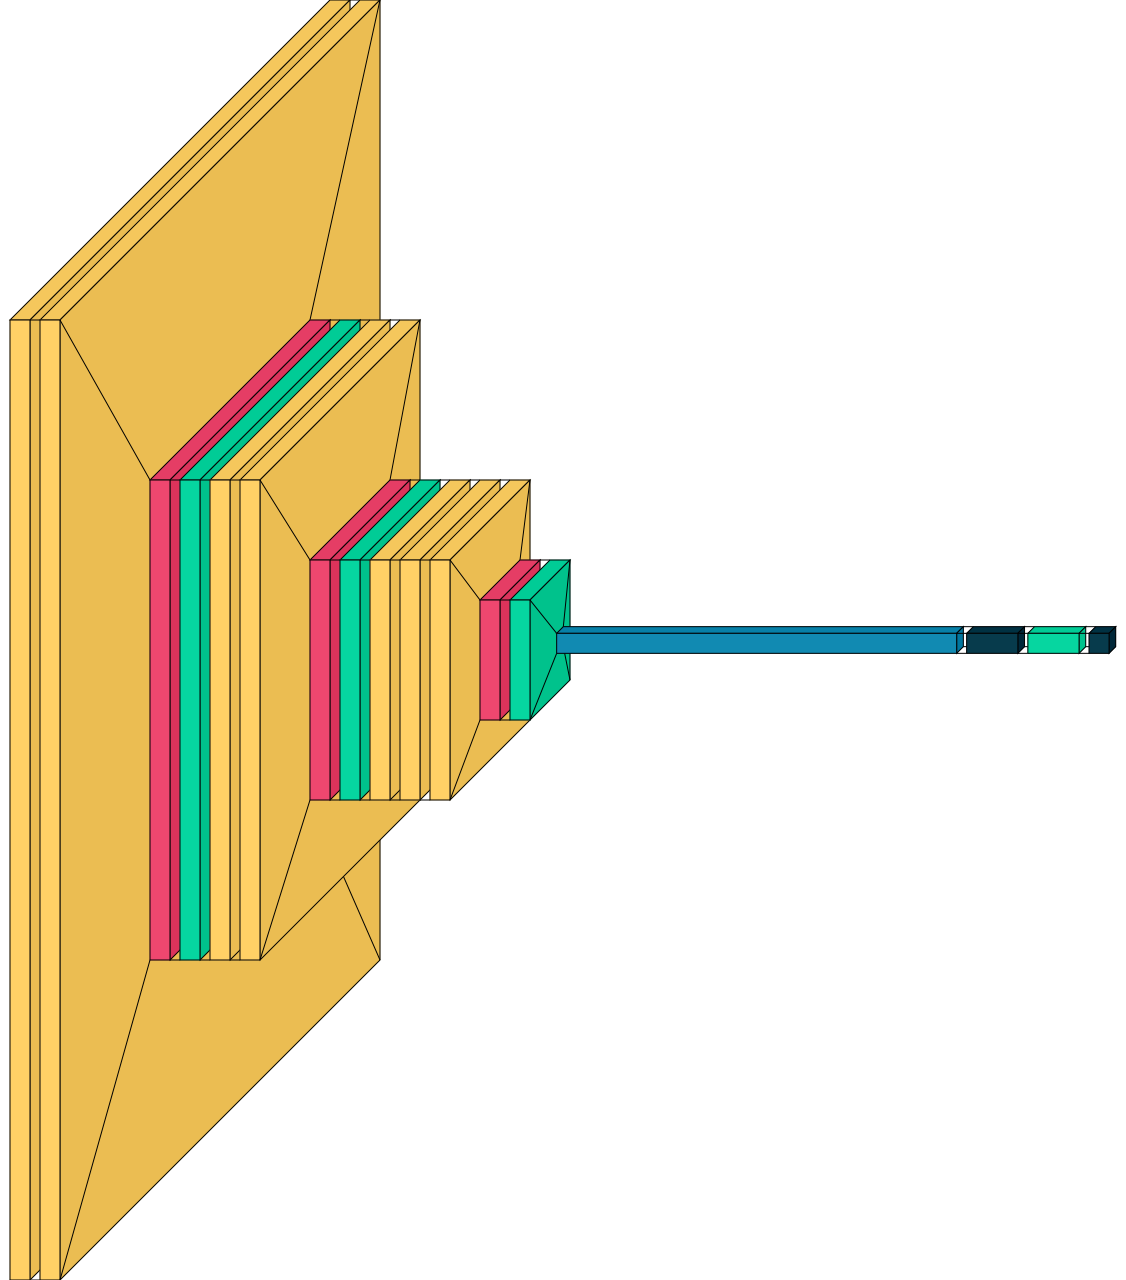

In [10]:
# visualizing model
import visualkeras
visualkeras.layered_view(model)

## Step 4 - Training the model

In [ ]:
# Training model
history = model.fit(train_dataset,epochs=10,steps_per_epoch = steps_per_epoch,
                    validation_data = val_dataset, validation_steps=validation_steps,
                    verbose=True, callbacks=[early_stop_cb, tensorboard_cb])

### Visualisering av träning
Jag loggade träningen i Tensorboard, här syns grafen för accuracyn på några olika varianter. Det fungerade bäst när jag lade till fler conv-lager och jag körde därför de modellerna längst. Efter cirka 40 epoker, eller 1000 iterationer närmade den sig ett maximum på ungefär 0.77 i accuracy på val_datan.  

<img src="lab_1_acc.png" alt="Alternative text" />

In [ ]:
# evaluating on test data
# model.evaluate(test_dataset)
# Eftersom min dator kraschade när jag kört min bästa modell och jag inte sparade den så har jag inte kvar resultatet på testdatan. Men jag fick 0.75 acc på testdatan.

## Svar på frågor:
- Motivera din modellarkitektur och val av relevanta hyperparametrar.  
    Genom experiment med olika data augmentation, regularisering, lagerstorlek och annat så märkte jag att det som gjorde störst positiv skillnad var antal conv-lager. 
- Vilka aktiveringsfunktioner har du använt? Varför?   
    ReLu - pga standard, ej experimenterat mycket med detta.
- Vilken loss funktion har du använt? Varför?  
    Categorical cross-entropy. Standard vi den här typen av problem, här jag har inte experimenterat.
- Har du använt någon databehandling? Varför?   
    Ja, jag har provat ganska mycket augmentation eftersom datasetet är relativt litet. Rotation, spegelvändning, shear och zoomning känns allihopa som att det inte förstör bilden. Möjligen blir bilder där människor ingår lite konstiga vid rotation, men det borde vara försumbart.
- Har du använt någon regulariseringsteknik? Motivera.   
    Jag har provat L1 och L2, batch normalization samt Dropout. Det som fungerade bäst var Dropout och det var det enda jag behöll till sist.
- Hur har modellen utvärderats?  
    Jag har använt Tensorboard och kört modellerna cirka 10 epoker åt gången, jag körde för det mesta early stopping på "val_loss" med patience 5 för att inte fastna för länge på en dålig modell.
- Är prestandan bra? Varför/ varför inte?   
    Jag kom till slut upp till cirka 0.75 accuracy på testdatan vilket jag är nöjd med.
- Vad hade du kunnat göra för att förbättra den ytterligare?  
    Antagligen göra ännu fler convlager eller denselager i slutet. Då skulle det dock börja ta lite för lång tid att träna.